In [1]:
import pandas as pd
import numpy as np
import scipy
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

#Medium
Refer to: https://rahulaga.medium.com/recommendation-systems-in-python-746d2184341d

# Movies Dataset
Data from Movie Lens. See Kaggle: https://www.kaggle.com/rounakbanik/the-movies-dataset

In [2]:
movies_metadata = pd.read_csv('https://raw.githubusercontent.com/rahulaga/ml-for-business/master/recommendation/kaggle/movies_metadata.csv')
movies_metadata.shape

/Users/agarwalrahul/.pyenv/versions/3.9.4/envs/py3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(45466, 24)

In [3]:
# Limit the data due to memory size limit in Colab for my free version. Connect to local then you can comment this out.
#movies_metadata = movies_metadata[:20000]

In [4]:
#id column has weird stuff
movies_metadata.loc[~movies_metadata['id'].astype(str).str.isdigit()]['id']

19730    1997-08-20
29503    2012-09-29
35587    2014-01-01
Name: id, dtype: object

In [5]:
#drop these 3 rows
movies_metadata.drop(movies_metadata.loc[~movies_metadata['id'].astype(str).str.isdigit()].index, inplace=True)
movies_metadata.loc[~movies_metadata['id'].astype(str).str.isdigit()]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count


In [6]:
#convert to int
movies_metadata = movies_metadata.astype({'id': 'int64'}, )

#copy id column
movies_metadata.rename(columns={'id':'movieId'}, inplace=True)

In [7]:
movies_metadata.head(5)

,adult,belongs_to_collection,budget,genres,homepage,movieId,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [8]:
movies_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45463 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45463 non-null  object 
 1   belongs_to_collection  4491 non-null   object 
 2   budget                 45463 non-null  object 
 3   genres                 45463 non-null  object 
 4   homepage               7779 non-null   object 
 5   movieId                45463 non-null  int64  
 6   imdb_id                45446 non-null  object 
 7   original_language      45452 non-null  object 
 8   original_title         45463 non-null  object 
 9   overview               44509 non-null  object 
 10  popularity             45460 non-null  object 
 11  poster_path            45077 non-null  object 
 12  production_companies   45460 non-null  object 
 13  production_countries   45460 non-null  object 
 14  release_date           45376 non-null  object 
 15  re

In [9]:
movies_metadata.isnull().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
movieId                      0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   3
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      3
runtime                    260
spoken_languages             3
status                      84
tagline                  25051
title                        3
video                        3
vote_average                 3
vote_count                   3
dtype: int64

# Ranking

See first part of  https://www.kaggle.com/abdokamr/recommendation-system-form-zero-to-hero

weightedRating(WR) = ((v/v+m).R) + ((m/v+m).C)

* v --> is the number of votes for the movie. (vote_count)
* m --> is the min votes required to be listed in chart. (based on negative vote)
* R --> is the average rating of the movie. (vote_average)
* C --> is the mean vote across the the whole report. (calculate from data)

In [10]:
# Function that computes the weighted rating of each movie
def weighted_rating(x, m=200, C=5):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [11]:
# Calculate mean of vote average column
C = movies_metadata['vote_average'].mean()

# Calculate the minimum number of votes required to be in the chart, m
m = movies_metadata['vote_count'].quantile(0.90)

print('C=',C,'m=',m)

C= 5.618207215134184 m= 160.0


In [12]:
# Filter out all qualified movies into a new DataFrame
q_movies = movies_metadata.copy().loc[movies_metadata['vote_count'] >= m]
q_movies.shape

(4555, 24)

In [13]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis= 1)

In [14]:
# Sort movies based on score calculated above
q_movies.sort_values(by= 'score', ascending= False, inplace= True)
q_movies[['movieId','title', 'vote_count', 'vote_average', 'score']].head(5)

,movieId,title,vote_count,vote_average,score
314,278,The Shawshank Redemption,8358.0,8.5,8.418205
834,238,The Godfather,6024.0,8.5,8.387532
12481,155,The Dark Knight,12269.0,8.3,8.247069
2843,550,Fight Club,9678.0,8.3,8.233185
292,680,Pulp Fiction,8670.0,8.3,8.225592


# Content Based

## Attempt 1
"Because you watched X here is what you may like"

Use movie overview text to create a tf-idf vector and then create a pairwise cosine distance similarity match.

In [15]:
# fill empty, someother way then filling will empty string is probabaly better approach
movies_metadata['overview'].fillna('', inplace=True)
print(movies_metadata['overview'].isnull().sum())

0


In [16]:
tfidf = TfidfVectorizer(stop_words= 'english')
tfidf_matrix = tfidf.fit_transform(movies_metadata['overview'])
tfidf_matrix.shape

(45463, 75827)

In [17]:
#these are the word it extracted given the overview text - the 75827 from above
#tfidf.get_feature_names()

In [18]:
#just to show what this matrix actually contains - the values are the "frequency" assigned to each word extracted as above for each movie
tfidf_matrix_transpose = pd.DataFrame(tfidf_matrix.toarray().transpose(),
                   index=tfidf.get_feature_names())
tfidf_matrix_transpose.columns = movies_metadata['title']
tfidf_matrix_transpose

title,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,House of Horrors,Shadow of the Blair Witch,The Burkittsville 7,Caged Heat 3000,Robin Hood,Subdue,Century of Birthing,Betrayal,Satan Triumphant,Queerama
00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000km,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000th,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
주식회사,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
찾기,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
첫사랑,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ﬁrst,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
#creating a pair-wise match (which is NxN - and have 1 diagonal as perfect match is to itself)
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
#cosine_sim

In [20]:
pd.DataFrame(cosine_sim, columns=movies_metadata['title'].values, index=movies_metadata['title'].values)

,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,House of Horrors,Shadow of the Blair Witch,The Burkittsville 7,Caged Heat 3000,Robin Hood,Subdue,Century of Birthing,Betrayal,Satan Triumphant,Queerama
Toy Story,1.000000,0.015041,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.005954,0.000000
Jumanji,0.015041,1.000000,0.046819,0.000000,0.000000,0.050188,0.000000,0.000000,0.102532,0.000000,...,0.0,0.0,0.0,0.011295,0.0,0.000000,0.066873,0.0,0.021986,0.009294
Grumpier Old Men,0.000000,0.046819,1.000000,0.000000,0.025094,0.000000,0.000000,0.006402,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.014025,0.000000
Waiting to Exhale,0.000000,0.000000,0.000000,1.000000,0.000000,0.007203,0.000000,0.008950,0.000000,0.000000,...,0.0,0.0,0.0,0.021541,0.0,0.026444,0.000000,0.0,0.009522,0.016413
Father of the Bride Part II,0.000000,0.000000,0.025094,0.000000,1.000000,0.000000,0.030263,0.000000,0.032754,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.007005,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Subdue,0.000000,0.000000,0.000000,0.026444,0.000000,0.025455,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,1.000000,0.000000,0.0,0.000000,0.000000
Century of Birthing,0.000000,0.066873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.049855,...,0.0,0.0,0.0,0.000000,0.0,0.000000,1.000000,0.0,0.000000,0.000000
Betrayal,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038268,0.000000,...,0.0,0.0,0.0,0.031411,0.0,0.000000,0.000000,1.0,0.000000,0.000000
Satan Triumphant,0.005954,0.021986,0.014025,0.009522,0.007005,0.000000,0.011525,0.005271,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,1.000000,0.000000


In [21]:
# Function that takes in movie title as input and outputs most similar movies
indices_by_title = pd.Series(index=movies_metadata['title'], data = movies_metadata.index).drop_duplicates()
def get_recommendations_attempt1(title):
    # Get the index of the movie that matches the title
    idx = indices_by_title[title]
    
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key = lambda x : x[1], reverse= True)
    
    # Get the scores of the 10 most similar movies, we stared with 1 because index 0 will give the same name of the input title 
    sim_scores = sim_scores[1:11]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    return movies_metadata.iloc[movie_indices]['title']

In [22]:
get_recommendations_attempt1('The Terminator')

582              Terminator 2: Judgment Day
13693                  Terminator Salvation
6388     Terminator 3: Rise of the Machines
18824                          Silent House
43045                              Harmonia
13470                             They Wait
14917                       Teenage Caveman
43308                          The Covenant
35284                         Another World
23932                       Appleseed Alpha
Name: title, dtype: object

## Attempt 2

In [23]:
#load ratings given by users to movies
user_ratings = pd.read_csv('https://raw.githubusercontent.com/rahulaga/ml-for-business/master/recommendation/kaggle/ratings_small.csv')
user_ratings.shape

(100004, 4)

In [24]:
user_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [25]:
user_ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


<AxesSubplot:>

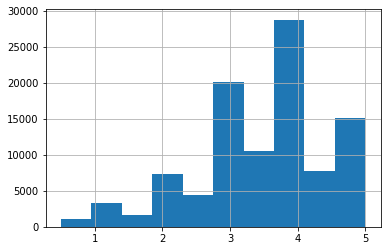

In [26]:
user_ratings.rating.hist()

In [27]:
# join users and movies, basically: select * from user, movies where user.userId=<input> and user.movieId=movies.movieId
def join_movies_and_user_rating(user_df, user_id):
  single_user_ratings = user_df[user_df.userId == user_id]
  return single_user_ratings.merge(movies_metadata, on='movieId')

In [28]:
#its weird but there are movie ids that have been rated by user but they dont exist in movies_metadata so note fewer rows after join.
#movies_metadata[movies_metadata.movieId=='31']

In [29]:
#example 
example_user_data = join_movies_and_user_rating(user_ratings,5)
print(example_user_data.shape)
example_user_data[['userId','movieId','title', 'rating', 'genres']].head(5)

(53, 27)


,userId,movieId,title,rating,genres
0,5,3,Shadows in Paradise,4.0,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name..."
1,5,104,Run Lola Run,4.0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam..."
2,5,141,Donnie Darko,4.0,"[{'id': 14, 'name': 'Fantasy'}, {'id': 18, 'na..."
3,5,150,48 Hrs.,4.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n..."
4,5,231,Syriana,3.5,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name..."


<AxesSubplot:>

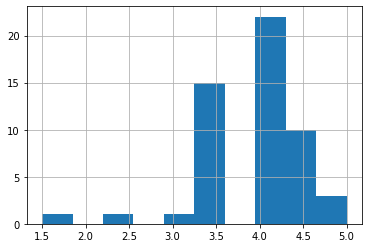

In [30]:
example_user_data['rating'].hist()

In [31]:
# Reference https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101
# some common functions
indices_by_movie_id = pd.Series(index=movies_metadata['movieId'], data = movies_metadata.index).drop_duplicates()

#return 1xNcols sparse matrix row for the single movie
def get_single_item_tfidf_vector(movie_id):
  idx = indices_by_movie_id[movie_id]
  item_tfidf_vector = tfidf_matrix[idx:idx+1]
  return item_tfidf_vector

#return a sparse matrix with rowsxNcols. rows equal number of movie ids requested
def get_items_tfidf_vector(movie_ids):
    items_list = [get_single_item_tfidf_vector(x) for x in movie_ids]
    items_list_tfidf_vector = scipy.sparse.vstack(items_list)
    return items_list_tfidf_vector

#single_vector=get_single_item_tfidf_vector(861)
#multiple_vectors=get_items_tfidf_vector((861,862))

In [32]:
#build a profile of user
#return the value assigned to each feature of tfidf based on weighted avg of items rated by a user
def build_single_user_profile(single_user_data_with_movies):
  #get all movies vectors, this is rowsxNcols with 1 row per movie
  rated_movies_vector = get_items_tfidf_vector(single_user_data_with_movies['movieId'])
  #get just the rating and convert row to col matrix 
  rated_movies_ratings = np.array(single_user_data_with_movies['rating']).reshape(-1,1)
  #matrix multiplicaiton
  multiply_movies_ratings = rated_movies_vector.multiply(rated_movies_ratings)
  #axis=0 sums by column
  weighted_avg = np.sum(multiply_movies_ratings, axis=0) / np.sum(rated_movies_ratings)
  weighted_avg_normalized = sklearn.preprocessing.normalize(weighted_avg)
  return weighted_avg_normalized

#look at example from above user
#profile = build_single_user_profile(example_user_data)

#find top words
#print(sorted(zip(tfidf.get_feature_names(), profile.flatten().tolist()), key=lambda x: x[1], reverse=True)[:50])

In [33]:
def get_recommendations_attempt2(user_df,user_id):
    # get the users rating and movies
    single_user_data_with_movies = join_movies_and_user_rating(user_df,user_id)

    # create a profile of user
    profile = build_single_user_profile(single_user_data_with_movies)

    # in attempt 1 we had a done a pair-wise cosine sim, now we will do it with this single user profile and all movies
    cosine_sim2 = cosine_similarity(profile, tfidf_matrix)
    similar_indices = cosine_sim2.argsort().flatten()
    
    # Sort the movies based on the similarity scores
    similar_items = sorted([(i, cosine_sim2[0,i]) for i in similar_indices], key=lambda x: x[1], reverse=True)
    
    # Get the movie indices
    movie_indices = [i[0] for i in similar_items]
    return movies_metadata.iloc[movie_indices]['title']

In [34]:
get_recommendations_attempt2(user_ratings, 5).head(10)

3822                        Get Carter
3144     Twin Peaks: Fire Walk with Me
1639                           Titanic
4468                 Gleaming the Cube
1164             To Kill a Mockingbird
12284      Aliens vs Predator: Requiem
8830                           Star 80
10942                      Silent Hill
13413                 My Name Is Bruce
8570                         The Prize
Name: title, dtype: object

# Collaborative

In [35]:
#random ratings for example
random_ratings = user_ratings[user_ratings['movieId'].isin(user_ratings['movieId'].sample(5))]#pick 5 random movies
random_ratings = random_ratings[random_ratings['userId'].isin(random_ratings['userId'].sample(10))]#of these pick 10 random users
pd.crosstab(index=random_ratings.userId, columns=random_ratings.movieId, values=random_ratings.rating, aggfunc=lambda x:x)
#note run a few times to get a nicer looking example

movieId,508,858,5349
userId,,,
164,NaN,NaN,3.5
175,NaN,NaN,4.0
203,NaN,5.0,NaN
234,NaN,NaN,3.0
283,4.5,NaN,NaN
430,NaN,4.5,4.0
461,2.5,5.0,4.0
480,NaN,4.0,3.5
562,NaN,4.0,5.0


<AxesSubplot:>

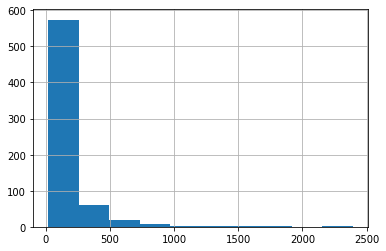

In [36]:
#very few users have given most ratings
user_ratings.groupby('userId')['movieId'].count().hist()

<AxesSubplot:>

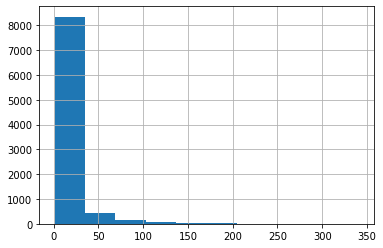

In [37]:
#very few movies even have ratings
user_ratings.groupby('movieId')['userId'].count().hist()

In [38]:
#reduce some data to speed up training
#based on https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Building%20Recommender%20System%20with%20Surprise.ipynb
min_movies_count = 50 # each movie has atleast this many ratings
filter_movies = user_ratings['movieId'].value_counts() > min_movies_count
filter_movies = filter_movies[filter_movies].index.tolist()

min_user_count = 20 # each user has rated atleast this many movies
filter_users = user_ratings['userId'].value_counts() > min_user_count
filter_users = filter_users[filter_users].index.tolist()

user_ratings_subset = user_ratings[(user_ratings['movieId'].isin(filter_movies)) & (user_ratings['userId'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(user_ratings.shape))
print('The new data frame shape:\t{}'.format(user_ratings_subset.shape))

The original data frame shape:	(100004, 4)
The new data frame shape:	(42345, 4)


## Using Surprise library
https://github.com/NicolasHug/Surprise

In [39]:
!pip install scikit-surprise

You should consider upgrading via the '/Users/agarwalrahul/.pyenv/versions/py3/bin/python -m pip install --upgrade pip' command.


In [54]:
from surprise import KNNWithMeans
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise import dump
from surprise import accuracy

Make ratings data usable by Surprise

In [41]:
# Surprise has builtin movie lens but continuing with same data used so far
# A Surprise reader is for reading ratings - https://surprise.readthedocs.io/en/stable/reader.html#surprise.reader.Reader
# The columns *must* correspond to user id, item id and ratings (in that order - see above)
s_reader = Reader(rating_scale=(0, 5))

#note: use subset vs full - makes a huge differerce time take
s_data_ratings = Dataset.load_from_df(user_ratings_subset[['userId', 'movieId', 'rating']], s_reader)
#s_data_ratings = Dataset.load_from_df(user_ratings[['userId', 'movieId', 'rating']], s_reader)

# by default Suprise creates a kFold dataset when loaded. Here just using full set instead
s_full_user_ratings = s_data_ratings.build_full_trainset()

# Full list of 'NaN' values we have above and we want to fill. See https://surprise.readthedocs.io/en/stable/trainset.html
s_full_testset = s_full_user_ratings.build_anti_testset()

Some common functions used later

In [42]:
# from https://surprise.readthedocs.io/en/stable/FAQ.html
from collections import defaultdict

def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [43]:
#followup from above to convert movie ids to names
def get_top_n_recommendations_for_uid(predictions, uid, n=10):
  top_n = get_top_n(predictions, n)
  df = pd.DataFrame(columns=['movieId','title','predicted_rating'])
  #convert to titles
  for movie_recommendation in top_n[uid]:
    movie_id = movie_recommendation[0]
    try:
      #there are movieIds in rating file that do no exist in movie metadata :(
      movie_title = movies_metadata.iloc[indices_by_movie_id[movie_id]]
      df = df.append({'movieId':movie_id,'title':movie_title['title'],'predicted_rating':movie_recommendation[1]}, ignore_index=True)
      #print(movie_id,movie_title['title'],'[predicted rating]',movie_recommendation[1])
      #print (movie_id, idx)
    except KeyError:
      df = df.append({'movieId':movie_id,'title':'***not found','predicted_rating':movie_recommendation[1]}, ignore_index=True)

  return df

### Using KNN with means and cosine similarity

This is "memory based", good ref: https://realpython.com/build-recommendation-engine-collaborative-filtering/

In [44]:
#user based
algo_knn_user = KNNWithMeans(sim_options={
    "name": "cosine",
    "user_based": True
})

#fit and predict
algo_knn_user.fit(s_full_user_ratings)                             
predictions_knn_user = algo_knn_user.test(s_full_testset)
dump.dump('./dump_file_knn_user', predictions_knn_user, algo_knn_user)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [45]:
# item based
algo_knn_item = KNNWithMeans(sim_options={
    "name": "cosine",
    "user_based": False
})

#fit and predict
algo_knn_item.fit(s_full_user_ratings)                             
predictions_knn_item = algo_knn_item.test(s_full_testset)
dump.dump('./dump_file_knn_item', predictions_knn_item, algo_knn_item)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [46]:
get_top_n_recommendations_for_uid(predictions_knn_item, 5)

,movieId,title,predicted_rating
0,913,The Thomas Crown Affair,4.453563
1,318,The Million Dollar Hotel,4.424623
2,2019,Hard Target,4.401615
3,904,***not found,4.367965
4,1252,Lonely Hearts,4.344555
5,899,Broken Blossoms,4.344353
6,527,Once Were Warriors,4.338922
7,1207,***not found,4.336425
8,58559,Hindle Wakes,4.325483
9,50,***not found,4.323655


In [47]:
get_top_n_recommendations_for_uid(predictions_knn_user, 5)

,movieId,title,predicted_rating
0,745,The Sixth Sense,4.570630
1,1148,***not found,4.472073
2,1204,***not found,4.433956
3,318,The Million Dollar Hotel,4.409010
4,1198,***not found,4.353301
5,527,Once Were Warriors,4.342804
6,246,Zatoichi,4.340510
7,899,Broken Blossoms,4.332899
8,608,Men in Black II,4.330261
9,913,The Thomas Crown Affair,4.323188


### Model based and SVD

Model based, same ref as above

In [48]:
#SVD
algo_svd = SVD()

algo_svd.fit(s_full_user_ratings)
predictions_svd = algo_svd.test(s_full_testset)

dump.dump('./dump_file_svd', predictions_svd, algo_svd)

In [49]:
get_top_n_recommendations_for_uid(predictions_svd, 5)

,movieId,title,predicted_rating
0,318,The Million Dollar Hotel,4.640707
1,1199,***not found,4.567984
2,745,The Sixth Sense,4.545435
3,1233,***not found,4.543782
4,1197,***not found,4.537534
5,1252,Lonely Hearts,4.505622
6,6016,The Good Thief,4.491272
7,904,***not found,4.489406
8,2324,The Wounded Angel,4.475871
9,527,Once Were Warriors,4.469131


# Evaluation

## RSME, MSE, MAE
https://surprise.readthedocs.io/en/stable/accuracy.html

In [60]:
# Using what surprise has https://surprise.readthedocs.io/en/stable/accuracy.html
def get_prediction_metrics(predictions):
  results = {}
  results['rmse'] = accuracy.rmse(predictions, verbose=False)
  results['mae'] = accuracy.mae(predictions, verbose=False)
  results['mse'] = accuracy.mse(predictions, verbose=False)
  return results

In [61]:
get_prediction_metrics(predictions_knn_user)

{'rmse': 0.5898139611086636,
 'mae': 0.45898623500016283,
 'mse': 0.34788050871869214}

In [63]:
get_prediction_metrics(predictions_knn_item)

{'rmse': 0.6100366586796218,
 'mae': 0.47107685250098996,
 'mse': 0.3721447249329973}

In [64]:
get_prediction_metrics(predictions_svd)

{'rmse': 0.5400703937694424,
 'mae': 0.4279831330798319,
 'mse': 0.2916760302262806}

In [78]:
# Adapted from https://github.com/NicolasHug/Surprise/blob/master/examples/benchmark.py
import time
import datetime
import random

import numpy as np
import six

from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNBaseline
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering

# The algorithms to cross-validate
classes = (SVD, SVDpp, NMF, SlopeOne, KNNBasic, KNNWithMeans, KNNBaseline,
           CoClustering, BaselineOnly, NormalPredictor)

np.random.seed(0)
random.seed(0)

kf = KFold(random_state=0)  # folds will be the same for all algorithms.

s_table = []
for klass in classes:
    start = time.time()
    out = cross_validate(klass(), s_data_ratings, ['rmse', 'mae'], kf)
    cv_time = str(datetime.timedelta(seconds=int(time.time() - start)))
    mean_rmse = '{:.3f}'.format(np.mean(out['test_rmse']))
    mean_mae = '{:.3f}'.format(np.mean(out['test_mae']))

    new_line = [klass.__name__, mean_rmse, mean_mae, cv_time]
    print([new_line])  # print current algo perf
    s_table.append(new_line)

#print(s_table)

[['SVD', '0.855', '0.654', '0:00:12']]
[['SVDpp', '0.838', '0.639', '0:04:33']]
[['NMF', '0.874', '0.669', '0:00:11']]
[['SlopeOne', '0.856', '0.652', '0:00:04']]
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
[['KNNBasic', '0.886', '0.676', '0:00:08']]
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
[['KNNWithMeans', '0.856', '0.654', '0:00:10']]
Estimating bias

In [79]:
pd.DataFrame(s_table, columns=['algorithm','rmse','mae','time']).sort_values('rmse')

,algorithm,rmse,mae,time
1,SVDpp,0.838,0.639,0:04:33
6,KNNBaseline,0.843,0.642,0:00:08
0,SVD,0.855,0.654,0:00:12
8,BaselineOnly,0.855,0.655,0:00:01
3,SlopeOne,0.856,0.652,0:00:04
5,KNNWithMeans,0.856,0.654,0:00:10
2,NMF,0.874,0.669,0:00:11
4,KNNBasic,0.886,0.676,0:00:08
7,CoClustering,0.888,0.691,0:00:03
9,NormalPredictor,1.353,1.073,0:00:01


## Precison and Recall @N

In [89]:
#From https://surprise.readthedocs.io/en/latest/FAQ.html#how-to-compute-precision-k-and-recall-k
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    print('precision:',sum(prec for prec in precisions.values()) / len(precisions))
    print('recall:',sum(rec for rec in recalls.values()) / len(recalls))
    #return precisions, recalls

In [90]:
precision_recall_at_k(predictions_knn_item)

precision: 0.9797507788161994
recall: 0.02678746029053797


In [91]:
precision_recall_at_k(predictions_knn_user)

precision: 0.9672897196261683
recall: 0.02650841355689903


In [92]:
precision_recall_at_k(predictions_svd)

precision: 0.9968847352024922
recall: 0.02736142573994906


In [52]:
#split into test train and test - only splitting the user ratings since that is what the model is going to predict
# grouping split by user id so that all ratings from a user are either in test or train
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_indices, test_indices in gss.split(user_ratings, groups=user_ratings['userId']):
  user_ratings_train = user_ratings.loc[train_indices]
  user_ratings_test = user_ratings.loc[test_indices]

print('train set', user_ratings_train.shape)
print('test set', user_ratings_test.shape)

# confirm none in common
user_ratings_train.merge(user_ratings_test, on='userId')

train set (76578, 4)
test set (23426, 4)


,userId,movieId_x,rating_x,timestamp_x,movieId_y,rating_y,timestamp_y
